In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from ydata_profiling import ProfileReport
from IPython.display import display
from libs.logger import configure_logging
from sklearn.model_selection import train_test_split

C:\Users\edgar\.conda\envs\t2_topicos\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
configure_logging()
log = logging.getLogger(__name__)
log.debug("testing the debug message")
# esto es para ocultar algunos mensajes de log de librerías como matplotlib
logging.getLogger("matplotlib").setLevel(logging.WARNING)


2025-05-19 11:27:40,118 [   DEBUG] __main__:3 (11404/MainThread)  - testing the debug message


In [3]:
# Carga del dataset en un dataframe y visualizacion de los primeros 5 registros.
df = pd.read_csv("../data/student-mat.csv", delimiter=";")
print(np.shape(df)) # este comando imprime la forma del dataframe
df.head(10)

(395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,10,15,15,15
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,12,12,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,6,6,5,6
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,16,18,19
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,14,15,15


Es recomendable no ejecutar la siguiente celda, la idea de esto es generar un reporte amplio y puede tardar bastante tiempo, lo mejor es ir a la carpeta `output` y abrir el archivo `student-report.html` para ver el reporte. Para eso haga click derecho en el archivo y seleccione `open with` y luego `web browser` y seleccione su navegador preferido.

In [4]:
# Generación del reporte y guardado en un archivo HTML en la carpeta output.
#profile = ProfileReport(df, title="Student Performance Report")
#profile.to_file("../output/student-report.html")

A modo de recomendación del profesor, se tienen las siguientes consideraciones:
* Considere que G3 tiene una fuerte correlación con G2 y G1, pero los modelos más útiles son
aquellos que no utilizan estas dos variables.
* Codifique las variables categóricas (por ejemplo, utilizando codificación one-hot).
* Divida los datos en conjuntos de entrenamiento y prueba
---
Revisando el [sitio oficial del set de datos](https://archive.ics.uci.edu/dataset/320/student+performance) se tiene que:
El conjunto de datos aborda el rendimiento estudiantil en educación secundaria de dos escuelas portuguesas, acá se menciona que:
* G3 es la calificación final de año del estudiante.
* G1 y G2 son las calificaciones de los dos primeros periodos del año.

Es por esto que se recomienda no usar G1 y G2 para predecir G3, ya que no utilizarlas nos daría una predicción más útil.

In [5]:
# Primero hay que ver el tipo de variables que manejan.
df.info()
# Ahora guardamos las variables de tipo object, estas son las variables categóricas.
cat_cols = df.select_dtypes(include='object').columns.tolist()
print(cat_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [6]:
# Se aplica la codificación one-hot a las variables categóricas y se visualizan
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded.head(10)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,True,False,False,False,True,True,False,False
1,17,1,1,1,2,0,5,3,3,1,...,False,False,False,True,False,False,False,True,True,False
2,15,1,1,1,2,3,4,3,2,2,...,True,False,True,False,True,False,True,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,True,False,False,True,True,True,True,True,True,True
4,16,3,3,1,2,0,4,3,2,1,...,False,False,False,True,True,False,True,True,False,False
5,16,4,3,1,2,0,5,4,2,1,...,True,False,False,True,True,True,True,True,True,False
6,16,2,2,1,2,0,4,4,4,1,...,True,False,False,False,False,False,True,True,True,False
7,17,4,4,2,2,0,4,1,4,1,...,True,False,True,True,False,False,True,True,False,False
8,15,3,2,1,2,0,4,2,2,1,...,True,False,False,True,True,False,True,True,True,False
9,15,3,4,1,2,0,5,5,1,1,...,True,False,False,True,True,True,True,True,True,False


In [7]:
# Las columnas a las que se aplicó la codificación one-hot quedaron con valores booleanos,
# es preferible que sean 0 y 1, así que se va a arreglar eso. Como el resto de variables ya era int, se hará lo siguiente:
df_encoded = df_encoded.astype(int)
print(df_encoded.info())
df_encoded.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                395 non-null    int64
 1   Medu               395 non-null    int64
 2   Fedu               395 non-null    int64
 3   traveltime         395 non-null    int64
 4   studytime          395 non-null    int64
 5   failures           395 non-null    int64
 6   famrel             395 non-null    int64
 7   freetime           395 non-null    int64
 8   goout              395 non-null    int64
 9   Dalc               395 non-null    int64
 10  Walc               395 non-null    int64
 11  health             395 non-null    int64
 12  absences           395 non-null    int64
 13  G1                 395 non-null    int64
 14  G2                 395 non-null    int64
 15  G3                 395 non-null    int64
 16  school_MS          395 non-null    int64
 17  sex_M           

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,1,0,0,0,1,1,0,0
1,17,1,1,1,2,0,5,3,3,1,...,0,0,0,1,0,0,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,1,0,1,0,1,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,1,0,0,1,1,1,1,1,1,1
4,16,3,3,1,2,0,4,3,2,1,...,0,0,0,1,1,0,1,1,0,0
5,16,4,3,1,2,0,5,4,2,1,...,1,0,0,1,1,1,1,1,1,0
6,16,2,2,1,2,0,4,4,4,1,...,1,0,0,0,0,0,1,1,1,0
7,17,4,4,2,2,0,4,1,4,1,...,1,0,1,1,0,0,1,1,0,0
8,15,3,2,1,2,0,4,2,2,1,...,1,0,0,1,1,0,1,1,1,0
9,15,3,4,1,2,0,5,5,1,1,...,1,0,0,1,1,1,1,1,1,0


Una de las cosas más complejas para realizar modelos o predicciones es entender los datos, sobre todo si un conjunto de datos tiene 42 columnas lo cual es bastante, en el reporte generado se puede observar una matriz de correlación, pero voy a mostrar como se ve en la siguiente celda.

In [8]:
corr_matrix = df_encoded.corr()
# Con tantas variables se ve asquerosamente mal la matriz como un heatmap, así que se mostrará como tabla.
display(corr_matrix.style.set_sticky(axis="columns"))

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
age,1.000000,-0.163658,-0.163438,0.070641,-0.004140,0.243665,0.053940,0.016434,0.126964,0.131125,0.117276,-0.062187,0.175230,-0.064081,-0.143474,-0.161579,0.377610,-0.028606,-0.146722,0.037847,0.029598,-0.082660,0.032488,-0.007732,-0.058256,-0.109842,0.007682,0.042963,-0.069993,0.018283,0.027172,-0.031932,-0.133558,0.398396,-0.251811,-0.140609,-0.035933,-0.103063,-0.086632,-0.209081,-0.112094,0.164669
Medu,-0.163658,1.000000,0.623455,-0.171639,0.064944,-0.236680,-0.003914,0.030891,0.064094,0.019834,-0.047123,-0.046878,0.100285,0.205341,0.215527,0.217147,-0.133333,0.078228,0.138804,-0.043068,-0.123565,0.251973,-0.235176,0.051764,0.454911,0.083398,-0.109887,-0.031834,0.259836,-0.008708,0.008229,0.106487,0.112375,-0.118635,-0.036029,0.183727,0.159700,0.108277,0.193263,0.168845,0.201463,0.039681
Fedu,-0.163438,0.623455,1.000000,-0.158194,-0.009175,-0.250408,-0.001370,-0.012846,0.043105,0.002386,-0.012631,0.014742,0.024473,0.190270,0.164893,0.152457,-0.079807,0.034878,0.072178,-0.058879,-0.088730,0.118501,-0.197077,0.028032,0.294526,0.163216,-0.253605,0.021306,0.347203,-0.009618,-0.014364,0.048724,-0.047265,-0.091250,0.037530,0.185496,0.086981,0.112643,0.157177,0.174566,0.127507,0.015602
traveltime,0.070641,-0.171639,-0.158194,1.000000,-0.100909,0.092239,-0.016808,-0.017025,0.028540,0.138325,0.134116,0.007501,-0.012944,-0.093040,-0.153198,-0.117142,0.242308,0.059722,-0.328096,0.063493,0.028265,-0.106708,0.036544,-0.050943,-0.051235,-0.088277,0.093214,-0.030232,0.014004,-0.080027,-0.001662,-0.033322,-0.057669,0.048758,-0.009246,-0.003286,-0.066420,-0.007766,-0.033338,-0.083508,-0.111302,0.021962
studytime,-0.004140,0.064944,-0.009175,-0.100909,1.000000,-0.173563,0.039731,-0.143198,-0.063904,-0.196019,-0.253785,-0.075616,-0.062700,0.160612,0.135880,0.097820,-0.090681,-0.306268,-0.020912,-0.073595,0.024294,-0.012977,-0.006288,-0.004476,-0.009009,0.121107,-0.040619,0.007162,-0.058225,-0.039620,-0.107842,0.193342,-0.024031,0.031724,0.037763,0.145228,0.167220,0.089877,0.081325,0.175081,0.059422,0.053285
failures,0.243665,-0.236680,-0.250408,0.092239,-0.173563,1.000000,-0.044337,0.091987,0.124561,0.136047,0.141962,0.065827,0.063726,-0.354718,-0.355896,-0.360415,0.059804,0.044436,-0.078578,-0.015769,-0.003339,-0.040859,0.006268,0.105430,-0.157771,-0.016593,-0.037792,0.082706,-0.074377,0.042511,-0.012203,-0.070127,-0.134498,0.291157,-0.000437,-0.055075,-0.188039,-0.069341,-0.100734,-0.300316,-0.063451,0.093137
famrel,0.053940,-0.003914,-0.001370,-0.016808,0.039731,-0.044337,1.000000,0.150701,0.064568,-0.077594,-0.113397,0.094056,-0.044354,0.022168,-0.018281,0.051363,-0.047926,0.058971,0.014258,-0.022776,0.025179,-0.061548,0.022736,0.056255,-0.022122,-0.013521,0.017534,0.051461,-0.069204,-0.012201,-0.019595,-0.000972,-0.010983,0.049548,-0.001345,-0.020436,0.000460,0.040687,-0.003581,0.024319,0.032768,-0.063816
freetime,0.016434,0.030891,-0.012846,-0.017025,-0.143198,0.091987,0.150701,1.000000,0.285019,0.209001,0.147822,0.075733,-0.058078,0.012613,-0.013777,0.011307,0.032988,0.238744,0.034878,0.017695,0.038717,-0.009094,-0.011640,0.021672,0.088508,-0.063738,0.040338,-0.051570,0.001675,-0.083249,0.039891,-0.050101,-0.028979,0.069438,-0.045465,0.010538,-0.064253,0.089728,-0.024696,-0.061244,0.051286,-0.011182
goout,0.126964,0.064094,0.043105,0.028540,-0.063904,0.124561,0.064568,0.285019,1.000000,0.266994,0.420386,-0.009577,0.044302,-0.149104,-0.162250,-0.132791,-0.007152,0.075897,0.068835,0.023064,0.003459,0.059252,-0.001660,0.014455,-0.021319,-0.021394,0.047488,-0.010554,-0.018830,-0.004410,-0.015182,-0.038297,0.080236,-0.012380,

In [9]:
# La tabla sigue siendo demasiado grande para interpretar bien los datos, así que voy a extraer G3
# y mostrar la correlación con el resto de columnas menos G1 y G2
corr_with_G3 = corr_matrix.corr()['G3'].drop(['G1', 'G2'])

# La idea igual es usar valor absoluto y ordenarlos para ver que tan fuerte es la correlación, más allá si es positiva o negativa
corr_with_G3_sorted = corr_with_G3.reindex(corr_with_G3.abs().sort_values(ascending=False).index)
display(corr_with_G3_sorted.to_frame(name='Correlation with G3').style.set_sticky(axis="index"))

,Correlation with G3
G3,1.000000
failures,-0.703623
Medu,0.429146
higher_yes,0.426985
age,-0.401646
goout,-0.391057
Fedu,0.374399
traveltime,-0.358702
romantic_yes,-0.314770
Walc,-0.285757


Para ver que variables incluir en todo esto seleccionaré todas las que sean mayores a 0.3 en valor absoluto y algunas seleccionadas personalmente que siento que podrían hacer sentido.
Algunas variables que no se entienden solamente con el nombre las definiré acá abajo:
* Pstatus: Si sus padres viven juntos o separados, juntos = 1, separados = 0
* Medu: Educación de la madre
* higher_yes es si quiere tomar educación superior o no
* El trabajo de la madre tiene bastante correlacion pero al ser como cuatro variables primero lo veré sin ella y luego lo incluiré si es necesario.


In [10]:
X = df_encoded[['failures','Medu','higher_yes','age','goout','Fedu','traveltime','romantic_yes','Pstatus_T','studytime','schoolsup_yes','guardian_other','guardian_mother','paid_yes','activities_yes','internet_yes','freetime','absences']]
y = df_encoded['G3']
X = X.values
y = y.values
# Normaliza X completo antes de dividir
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X = np.hstack((np.ones((X.shape[0], 1)), X))  # Agregar intercepto

# Luego divide
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Training data:",np.shape(X_train))
print("Test data:",np.shape(X_test))

Training data: (316, 19)
Test data: (79, 19)


## Modelo de regresión lineal múltiple
El modelo de regresión lineal tiene la forma:

$$ \hat{y} = \beta_0 + \beta_{1}*x_{1} + \beta_{2}*x_{2} + ... + \beta_{n}*x_{n} $$

$$\hat{y}=X\beta$$

Donde $\hat{y}$ es la predicción que queremos hacer

$\beta_0$ es el término independiente

$\beta_{n}$ es un vector de coeficientes

$x_{n}$ son los valores de las variables independientes del dataset.

El objetivo es obtener $\beta_0$ y $\beta_{n}$  tales que error cuadrático (residuo) , definido como:

$$RSS = \varepsilon_i^2 = \sum\limits_{i=1}^n(y_{i} - \hat{y})^2$$

Sea el mínimo.

Para ello se tiene que resolver la siguiente ecuación:

$$\beta = (X^TX)^{-1}X^Ty$$
$$\hat{y} = X(X^TX)^{-1}X^Ty $$

## Calculo de los coeficientes

In [13]:
# Recordatorio: X ya tiene una columna de unos como intercepto, la vamos a quitar
X_train_sklearn = X_train[:, 1:]  # Quitamos la columna de 1s
X_test_sklearn = X_test[:, 1:]

# Modelo
model = LinearRegression()
model.fit(X_train_sklearn, y_train)

# Predicción
y_pred_sklearn = model.predict(X_test_sklearn)

# Métricas
r2_sklearn = r2_score(y_test, y_pred_sklearn)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)

print(f"[LinearRegression sklearn] R²: {r2_sklearn:.3f}")
print(f"[LinearRegression sklearn] MSE: {mse_sklearn:.3f}")

[LinearRegression sklearn] R²: 0.046
[LinearRegression sklearn] MSE: 19.944


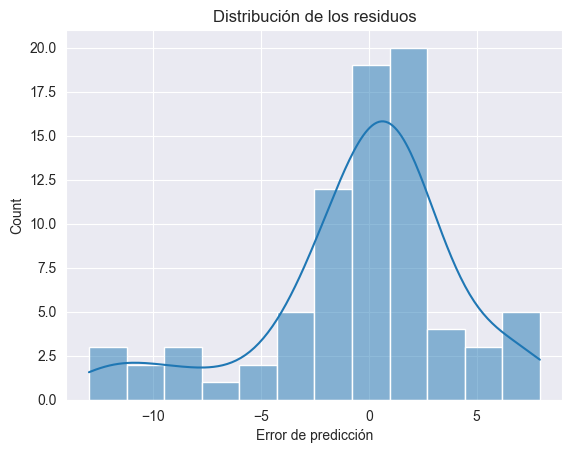

In [14]:
import seaborn as sns
residuals = y_test - y_pred_sklearn
sns.histplot(residuals, kde=True)
plt.title("Distribución de los residuos")
plt.xlabel("Error de predicción")
plt.show()
